## This is the first file for the "Using Air Pollution..." project. It loads and prepares the data. 

### 1. Import packages

In [1]:
import rasterio, fiona
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d
from rasterstats import zonal_stats
import glob
from functools import reduce

### 2. Set path 

In [2]:
# Change your path in to wherever you have downloaded the datasets listed in the README file
path_in = r"C:\Users\lilac2\Box\ACE592_Pollution\Data"
path_out = r"C:\Users\lilac2\Box\ACE592_Pollution\Output"

### 3. Read in Mexico municipality shapefile and pollution raster files

In [3]:
#Read in shape file for mexico (municipalities)
mexico = geopandas.read_file(path_in+"/boundary_shp/mex_admbnda_adm0_govmex_20200618.shp")
mex_district = geopandas.read_file(path_in+"/boundary_shp/mex_admbnda_adm2_govmex_20200618.shp") 

In [4]:
#Read in raster files using rasterio
pm2009 = rasterio.open(path_in+"/pollution/gwr_pm25_2009.tif")  
pm2014 = rasterio.open(path_in+"/pollution/gwr_pm25_2014.tif")  

In [5]:
#check coordinates
pm2009.crs == mex_district.crs, pm2014.crs == mex_district.crs

(True, True)

### 4. Write a function to clip a raster to a shapefile

In [6]:
#Function to send geometry from shapefile to raster
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# Function to clip_raster
def clip_raster(raster, vector, filename):
    img_out, img_transform = mask(raster,getFeatures(vector), crop=True)  
    out_meta = raster.meta.copy()
    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = img_transform
    with rasterio.open(path_in+'/pollution/clipped_rasters/'+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open(path_in+'/pollution/clipped_rasters/'+filename+".tif")
    

### 5. Write a function to calculate statistics of variables at municipality level

In [7]:
#Function to retrive mean values at district level
def get_zonal_stats(vector, raster):
    result = zonal_stats(vector, raster, stats = ['min', 'max','mean','std'], nodata=np.nan, geojson_out = True)
    geostats = geopandas.GeoDataFrame.from_features(result)
    return geostats

### 6. Clip rasters to Mexico shapefile and calculae zonal statistics

In [8]:
#Clipping Rasters to mexico
pm2009_c = clip_raster(pm2009, mexico, "pm2009_clip")
pm2014_c = clip_raster(pm2014, mexico, "pm2014_clip")

#Doing zonal stats 
pollution_mean_2009 = get_zonal_stats(mex_district, path_in+'/pollution/clipped_rasters/pm2009_clip.tif')
pollution_mean_2014 = get_zonal_stats(mex_district, path_in+'/pollution/clipped_rasters/pm2014_clip.tif')

C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\numpy\core\_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\rasterstats\main.py:231: UserWarning: Warning: converting a masked element to nan.
  feature_stats['std'] = float(masked.std())


### 7. Plot pollution levels for 2009 and 2014

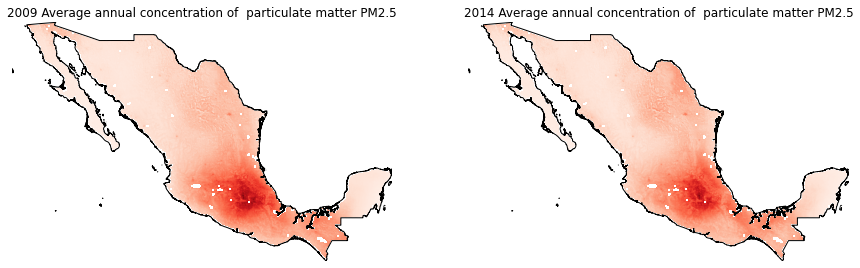

In [9]:
fig, ax = plt.subplots(1, 2,figsize=(15, 15))
show(pm2009_c, ax=ax[0],cmap="Reds")
mexico.plot(ax=ax[0], facecolor='none', edgecolor='black')
ax[0].axis('off')
ax[0].set_title("2009 Average annual concentration of  particulate matter PM2.5");
# mex_district.plot(ax=ax[0], facecolor='none',edgecolor = 'black')

show(pm2014_c, ax=ax[1],cmap="Reds")
mexico.plot(ax=ax[1], facecolor='none', edgecolor='black')
ax[1].axis('off')
ax[1].set_title("2014 Average annual concentration of  particulate matter PM2.5");
# mex_district.plot(ax=ax[1], facecolor='none',edgecolor = 'black')


### 8. Combine pollution data from 2009 and 2014 to create a long format dataframe: pm_df

In [10]:
#Dataframe in long format
pm_df09 = pollution_mean_2009[['ADM1_ES', 'ADM2_ES', 'ADM2_PCODE', 'Shape_Area','min', 'max','mean','std']]
pm_df09["year"] = 2009

pm_df14 = pollution_mean_2014[['ADM1_ES', 'ADM2_ES', 'ADM2_PCODE', 'Shape_Area','min', 'max','mean','std']]
pm_df14["year"] = 2014

pm_df = pd.concat([pm_df09, pm_df14])
pm_df = pm_df.rename(columns={"mean": "poll_mean","min": "poll_min","max": "poll_max","std": "poll_std"})


<ipython-input-10-d54e1f2ea83b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_df09["year"] = 2009
<ipython-input-10-d54e1f2ea83b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_df14["year"] = 2014


### 9. Combine pollution data from 2009 and 2014 to create a wide format dataframe: pm_df2

In [11]:
#Creating a wide format dataframe
pm_df09_2 = pm_df09.copy()
pm_df09_2 = pm_df09_2.rename(columns={"mean": "poll_mean09","min": "poll_min09","max": "poll_max09","std": "poll_std09"})
pm_df14_2 = pm_df14.copy()
pm_df14_2 = pm_df14_2.rename(columns={"mean": "poll_mean14","min": "poll_min14","max": "poll_max14","std": "poll_std14"})

pm_df2 = pd.concat([pm_df09_2, pm_df14_2], axis =1, join = "inner")

pm_df2 = pm_df2.loc[:, ~pm_df2.columns.duplicated()]
pm_df2.shape

(2456, 13)

### 10. Repeat above steps for nightlight rasters

In [12]:
#read in night light raster files
nl2009 = rasterio.open(path_in+"/nightlights/Harmonized_DN_NTL_2009_calDMSP.tif")
nl2014 = rasterio.open(path_in+"/nightlights/Harmonized_DN_NTL_2014_simVIIRS.tif")

In [13]:
#clip rasters to the shape of mexico using clip_raster function
nl2009_c = clip_raster(nl2009, mexico, "nl2009_clip")
nl2014_c = clip_raster(nl2014, mexico, "nl2014_clip")

#calculate zonal statistics
nightlight_mean_2009 = get_zonal_stats(mex_district, path_in+'/pollution/clipped_rasters/nl2009_clip.tif')
nightlight_mean_2014 = get_zonal_stats(mex_district, path_in+'/pollution/clipped_rasters/nl2014_clip.tif')

### 11. Plot nightlights for 2009 and 2014

Text(0.5, 1.0, '2014 Average annual luminosity')

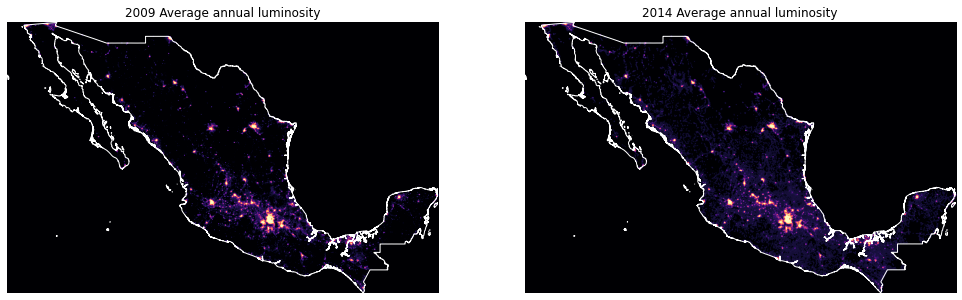

In [14]:
fig, ax = plt.subplots(1,2,figsize=(17, 17))
show(nl2009_c, ax=ax[0], cmap = "magma")
mexico.plot(ax=ax[0], facecolor='none', edgecolor='white')
ax[0].axis('off')
ax[0].set_title("2009 Average annual luminosity")


show(nl2014_c, ax=ax[1], cmap = "magma")
mexico.plot(ax=ax[1], facecolor='none', edgecolor='white')
ax[1].axis('off')
ax[1].set_title("2014 Average annual luminosity")


### 12. Combine nightlight data from 2009 and 2014 to create a long format dataframe: nl_df

In [15]:
nl_df09 = nightlight_mean_2009[['ADM1_ES', 'ADM2_ES', 'ADM2_PCODE', 'Shape_Area','min', 'max','mean','std']]
nl_df09["year"] = 2009

nl_df14 = nightlight_mean_2014[['ADM1_ES', 'ADM2_ES', 'ADM2_PCODE', 'Shape_Area','min', 'max','mean','std']]
nl_df14["year"] = 2014

nl_df = pd.concat([nl_df09, nl_df14])
nl_df = nl_df.rename(columns={"mean": "night_mean","min":"night_min","max":"night_max","std":"night_std"})


<ipython-input-15-f5859b211fb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nl_df09["year"] = 2009
<ipython-input-15-f5859b211fb9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nl_df14["year"] = 2014


### 13. Combine nightlight data from 2009 and 2014 to create a wide format dataframe: nl_df2

In [16]:
#Wide format dataset
nl_df09_2 = nl_df09.copy()
nl_df09_2 = nl_df09_2.rename(columns={"mean": "night_mean09","min": "night_min09","max": "night_max09","std": "night_std09"})
nl_df14_2 = nl_df14.copy()
nl_df14_2 = nl_df14_2.rename(columns={"mean": "night_mean14","min": "night_min14","max": "night_max14","std": "night_std14"})

nl_df2 = pd.concat([nl_df09_2, nl_df14_2], axis =1, join = "inner")
nl_df2 = nl_df2.loc[:, ~nl_df2.columns.duplicated()]

### 14. Combine nightlight and pollution dataframes

* df_final is the long format version
* df_final2 is the wide format version

In [17]:
#df_final is the data set with pollution and nightlights data 
df_final = pd.merge(pm_df, nl_df)
#df_final_2 is the data set with wide format
df_final_2 = pd.merge(pm_df2, nl_df2)

df_final.shape,df_final_2.shape

((4912, 13), (2456, 21))

### 15. Read in monthly temperature (CHIRTS) data for 2009 and 2014

In [18]:
#ADM2_PCODE is the unique district ID
subset=['Shape_Area', 'ADM2_ES', 'ADM2_PCODE']
mex_district_id = mex_district[subset]

In [19]:
#Get temperature data list
tmax_list = glob.glob(path_in+'/temp_month/*.tif')
tmax_list = [x for x in tmax_list] 

### 16. Write function to calculate zonal mean

In [20]:
#function to calculate zonal mean
def zonal_mean (shpfile, rasfile):
    temp = pd.DataFrame(zonal_stats(shpfile,\
                                         rasfile,\
                                         stats=("mean","std",'max','min'), nodata=np.nan))\
                                         .astype('float16').reset_index()
    return temp

### 17. Compute zonal statistics 

In [21]:
## Compute Zonal Statistics at the district level and rename columns
mini=[]
maxi=[]
mean=[]
std=[]

result=[]

# Compute Zonal Statistics at the district level using zonal_mean functiona
for i,j in enumerate(tmax_list):
    #set column name
    #tmax_list[i][-12:-4] - gets a substring - eg. ".2009.01"
    mini.append('min_'+'tmax'+tmax_list[i][-12:-4].replace(".", "_"))
    maxi.append('max_'+'tmax'+tmax_list[i][-12:-4].replace(".", "_"))
    mean.append('mean_'+'tmax'+tmax_list[i][-12:-4].replace(".", "_"))
    std.append('std_'+'tmax'+tmax_list[i][-12:-4].replace(".", "_"))
    #put them in result list
    result.append(zonal_mean(mex_district, j))

temp_clean=[]
# rename column
for l,k in enumerate(result):
    mn = mini[l]
    mx = maxi[l]
    nm = mean[l]
    sd = std[l]
    temp_clean.append(k.rename(columns={'min':mn,'max':mx,'mean':nm,'std':sd}))

In [22]:
## Merge district Tmax_mean using reduce function
Tmax=reduce(lambda x, y: pd.merge(x, y, on='index'), temp_clean)

In [23]:
# Disaggregate by each year
Tmax_2009 = Tmax[[x for x in Tmax if "2009" in x]]
Tmax_2014 = Tmax[[x for x in Tmax if "2014" in x]]

Tmax_2009['year']='2009'
Tmax_2014['year']='2014'

# drop district with negative values
Tmax_2009 = Tmax_2009[Tmax_2009.mean_tmax_2009_01 > 0]
Tmax_2014 = Tmax_2014[Tmax_2014.mean_tmax_2014_01 > 0]

#merging municipality ID
Tmax_2009_month = mex_district_id.join(Tmax_2009)
Tmax_2014_month = mex_district_id.join(Tmax_2014)

<ipython-input-23-5d670104e1ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmax_2009['year']='2009'
<ipython-input-23-5d670104e1ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmax_2014['year']='2014'


### 18. Read in monthly rainfall (CHIRPS) data for 2009 and 2014

In [24]:
prec_list = glob.glob(path_in+'/chirps/*.tif')

### 19. Compute zonal statistics 

In [25]:
## Compute Zonal Statistics at the district level and rename columns
mini=[]
maxi=[]
mean=[]
std=[]

result=[]

# Compute Zonal Statistics at the district level using zonal_mean functiona
for i,j in enumerate(prec_list):
    #set column name
    mini.append('min_'+'prec'+prec_list[i][-12:-4].replace(".", "_"))
    maxi.append('max_'+'prec'+prec_list[i][-12:-4].replace(".", "_"))
    mean.append('mean_'+'prec'+prec_list[i][-12:-4].replace(".", "_"))
    std.append('std_'+'prec'+prec_list[i][-12:-4].replace(".", "_"))
    #put them in result list
    result.append(zonal_mean(mex_district, j))

prec_clean=[]
# rename column
for l,k in enumerate(result):
    mn = mini[l]
    mx = maxi[l]
    nm = mean[l]
    sd = std[l]
    prec_clean.append(k.rename(columns={'min':mn,'max':mx,'mean':nm,'std':sd}))

In [26]:
Prec=reduce(lambda x, y: pd.merge(x, y, on='index'), prec_clean)

In [27]:
# Disaggregate by each year

Prec_2009 = Prec[[x for x in Prec if "2009" in x]]
Prec_2014 = Prec[[x for x in Prec if "2014" in x]]

Prec_2009['year']='2009'
Prec_2014['year']='2014'

# drop district with negative values
Prec_2009 = Prec_2009[Prec_2009.min_prec_2009_01 > 0]
Prec_2014 = Prec_2014[Prec_2014.min_prec_2014_01 > 0]

#Tmax_2004_month = mex_district.join(Tmax_2004)
Prec_2009_month = mex_district_id.join(Prec_2009)
Prec_2014_month = mex_district_id.join(Prec_2014)

<ipython-input-27-48f4ef281f67>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Prec_2009['year']='2009'
<ipython-input-27-48f4ef281f67>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Prec_2014['year']='2014'


### 20. Rename temperature and rainfall data 
Need to create two versions (wide and long formats) to merge with above pollution+nightlight data

In [28]:
df_r_09 = Prec_2009_month
df_r_14 = Prec_2014_month
df_t_09 = Tmax_2009_month
df_t_14 = Tmax_2014_month

### 21. Merge with nightlight_pollution wide dataframe named df_final_2 from above 
#### (note, we don't use the wide format, but its created if you want to use it)

In [29]:
#dataframe with nightlights and pollution in wide format
df_final_2 = pd.concat([df_final_2,df_r_09,df_r_14,df_t_09,df_t_14], axis =1, join = "inner")
#drop duplicates
df_final_2 = df_final_2.loc[:, ~df_final_2.columns.duplicated()]
df_final_2["new_cod"] = df_final_2["ADM2_PCODE"].str[2:]
df_final_2.shape

(2456, 214)

From above, the wide format has 2456 municipalities and 214 features

### 22. Read in economic activity data and merge together

In [30]:
mex_econ = geopandas.read_file(path_in+"/municipios4/municipios4.shp")
#keep relevant variables only
mx_ec = mex_econ[['new_cod','NOM_MUN','sqkms','year','tpop','gva_r']]
#keep if year is 2009
mx_09 = mx_ec[mx_ec['year'].isin([2009.0])]
#rename gdp variable
mx_09 = mx_09.rename(columns={"gva_r": "gva_r09"})
#keep if year is 2014
mx_14 = mx_ec[mx_ec['year'].isin([2014.0])]
#rename gdp variable
mx_14 = mx_14.rename(columns={"gva_r": "gva_r14"})

In [31]:
mx_09.shape,mx_14.shape

((2377, 6), (2377, 6))

In [32]:
mx_both = pd.merge(mx_09, mx_14, on=["new_cod", "NOM_MUN","sqkms","tpop"])
mx_both.columns

Index(['new_cod', 'NOM_MUN', 'sqkms', 'year_x', 'tpop', 'gva_r09', 'year_y',
       'gva_r14'],
      dtype='object')

### 23. Final Merge of all data: Nightlights+Pollution+Temperature+Rainfall+Economic Activity (Wide Format)

In [33]:
result_wide = pd.merge(df_final_2, mx_both, on=['new_cod'])
#dropping year columns
result_wide = result_wide.drop(columns=["year","year_x","year_y"])
#Save as csv to use in analysis
result_wide.to_csv(path_out+"\Data_Final_wide.csv", index = False)

In [34]:
result_wide.head(10)

,ADM1_ES,ADM2_ES,ADM2_PCODE,Shape_Area,poll_min09,poll_max09,poll_mean09,poll_std09,poll_min14,poll_max14,...,min_tmax_2014_12,max_tmax_2014_12,mean_tmax_2014_12,std_tmax_2014_12,new_cod,NOM_MUN,sqkms,tpop,gva_r09,gva_r14
0,Yucatán,Abalá,MX31001,0.025369,3.5,4.000000,3.713043,0.117061,3.6,4.1,...,29.015625,29.296875,29.140625,0.090027,31001,Abalá,285.296112,6356.0,17399.419922,7553.0
1,Coahuila de Zaragoza,Abasolo,MX05001,0.067645,5.3,9.400000,7.142075,0.831193,5.6,10.6,...,20.187500,21.578125,21.218750,0.360107,05001,Abasolo,643.653076,1070.0,881.274109,2590.0
2,Guanajuato,Abasolo,MX11001,0.053291,12.7,16.700001,14.848406,0.804410,10.3,13.4,...,22.156250,23.062500,22.718750,0.292480,11001,Abasolo,620.988098,84332.0,327685.250000,778614.0
3,Nuevo León,Abasolo,MX19001,0.004224,6.7,8.100000,7.512195,0.307781,6.7,8.2,...,21.203125,21.203125,21.203125,0.000658,19001,Abasolo,46.752651,2791.0,46076.492188,129604.0
4,Tamaulipas,Abasolo,MX28001,0.165112,4.7,8.000000,6.428087,0.659819,4.2,6.9,...,22.375000,23.125000,22.796875,0.178955,28001,Abasolo,1806.951050,12070.0,91860.429688,161572.0
5,Oaxaca,Abejones,MX20001,0.010750,8.4,12.700000,10.789523,1.060990,6.1,9.0,...,22.968750,23.906250,23.375000,0.411621,20001,Abejones,146.200104,1084.0,764.012634,1244.0
6,Chiapas,Acacoyagua,MX07001,0.020883,7.3,10.000000,8.778641,0.512684,6.6,9.1,...,27.031250,33.843750,31.062500,2.468750,07001,Acacoyagua,283.829895,16814.0,35302.945312,51736.0
7,Puebla,Acajete,MX21001,0.015186,18.1,22.500000,20.731372,1.040140,14.1,18.6,...,20.421875,21.875000,21.062500,0.464111,21001,Acajete,152.344299,60353.0,323384.062500,383964.0
8,Veracruz de Ignacio de la Llave,Acajete,MX30001,0.008393,12.6,14.500000,13.686206,0.421320,9.4,10.7,...,18.296875,19.390625,18.796875,0.503906,30001,Acajete,92.693878,8223.0,3300.244385,61014.0
9,Chiapas,Acala,MX07002,0.040731,8.2,12.000000,10.486828,0.716749,6.7,9.3,...,28.312500,29.687500,29.140625,0.430664,07002,Acala,445.533112,28947.0,152561.968750,78910.0


### 24. Final Merge of all data: Nightlights+Pollution+Temperature+Rainfall+Economic Activity (Long Format)
#### Note: we had to perform checks on variable names in order to create the panel

In [35]:
#creating list to change columns names to be the same for 2009 and 2014 - Precipitation
stats_list = ["min","max","mean","std"]
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
main_col = []
for i in stats_list:
    for j in month:
        a = i+"_prec_"+j
        main_col.append(a)
        
main_col = sorted(main_col)
main_col.insert(0,"ADM2_ES")
main_col.insert(1,"ADM2_PCODE")
main_col.insert(2,"Shape_Area")
main_col.append("year")

In [36]:
#creating list to change columns names to be the same for 2009 and 2014 - Temperature
stats_list = ["min","max","mean","std"]
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
main_col_t = []
for i in stats_list:
    for j in month:
        a = i+"_tmax_"+j
        main_col_t.append(a)
        
main_col_t = sorted(main_col_t)
main_col_t.insert(0,"ADM2_ES")
main_col_t.insert(1,"ADM2_PCODE")
main_col_t.insert(2,"Shape_Area")
main_col_t.append("year")

In [37]:
#sorting the columns in dataframe
df_r_09 = df_r_09.sort_index(axis=1)
df_r_14 = df_r_14.sort_index(axis=1)
df_t_09 = df_t_09.sort_index(axis=1)
df_t_14 = df_t_14.sort_index(axis=1)

In [38]:
#assigning column names to dataframe
df_r_09.columns = main_col
df_r_14.columns = main_col
df_t_09.columns = main_col_t
df_t_14.columns = main_col_t

#2009 and 2014 by years
prec = pd.concat([df_r_09, df_r_14])
temp = pd.concat([df_t_09, df_t_14])

In [39]:
#dataframe with temperature and precipitation
prectemp = pd.concat([prec, temp], axis = 1)
prectemp = prectemp.reset_index()

In [40]:
#merging df_final (nightlights+pollution) and above created prectemp dataframe
df = pd.concat([df_final, prectemp], axis=1)
#drop rows with NaN values
df.dropna(inplace =True)

#drop duplicate columns created due to merging
df = df.loc[:, ~df.columns.duplicated()]
#drop index column 
df.drop('index', axis=1, inplace=True)

In [41]:
#creating a variable new_code to create matching key with economic activity data
df.sort_values(['ADM2_PCODE','year'], inplace = True)
df["new_cod"] = df["ADM2_PCODE"].str[2:]
#keeping relevant variables from economic activity data
mx_ec = mex_econ[['new_cod','NOM_MUN','sqkms','year','tpop','gva_r']]

In [42]:
mx_ec.head(10)

,new_cod,NOM_MUN,sqkms,year,tpop,gva_r
0,01001,Aguascalientes,1805.399048,1989.0,506274.0,9.115599e+06
1,01001,Aguascalientes,1805.399048,1986.0,432864.0,7.507757e+06
2,01001,Aguascalientes,1805.399048,2004.0,757670.0,3.373052e+07
3,01001,Aguascalientes,1805.399048,2009.0,851607.0,4.802176e+07
4,01001,Aguascalientes,1805.399048,1994.0,614941.0,1.807712e+07
5,01001,Aguascalientes,1805.399048,1999.0,678812.0,2.435605e+07
6,01001,Aguascalientes,1805.399048,2014.0,851607.0,3.902378e+07
7,01002,Asientos,541.353821,1999.0,37763.0,6.288541e+04
8,01002,Asientos,541.353821,2009.0,45492.0,6.141719e+04
9,01002,Asientos,541.353821,2014.0,45492.0,5.684490e+05


In [43]:
#keep only data from years 2009 and 2014
mx_years = mx_ec[mx_ec['year'].isin([2009.0,2014.0])]
#sort based on municipality and year
mx_years.sort_values(['new_cod','year'], inplace = True)

<ipython-input-43-df0036aea9ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mx_years.sort_values(['new_cod','year'], inplace = True)


In [44]:
#reset index for both years
mx_years = mx_years.reset_index()
df = df.reset_index()

In [45]:
df.shape,mx_years.shape

((4488, 111), (4754, 7))

#### Merging all data (Long format)

In [46]:
result = (pd.merge(df, mx_years, left_on=['new_cod','year'],right_on=['new_cod','year']))
result.columns

Index(['index_x', 'ADM1_ES', 'ADM2_ES', 'ADM2_PCODE', 'Shape_Area', 'poll_min',
       'poll_max', 'poll_mean', 'poll_std', 'year',
       ...
       'std_tmax_09', 'std_tmax_10', 'std_tmax_11', 'std_tmax_12', 'new_cod',
       'index_y', 'NOM_MUN', 'sqkms', 'tpop', 'gva_r'],
      dtype='object', length=116)

In [47]:
#keep only revelant variables
result2 = result[['ADM1_ES','ADM2_ES','ADM2_PCODE','Shape_Area', 'poll_min', 'poll_max', 'poll_mean', 'poll_std', 'year', 'night_min', 'night_max', 'night_mean', 'night_std', 'max_prec_01', 'max_prec_02', 'max_prec_03', 'max_prec_04', 'max_prec_05', 'max_prec_06', 'max_prec_07', 'max_prec_08', 'max_prec_09', 'max_prec_10', 'max_prec_11', 'max_prec_12', 'mean_prec_01', 'mean_prec_02', 'mean_prec_03', 'mean_prec_04', 'mean_prec_05', 'mean_prec_06', 'mean_prec_07', 'mean_prec_08', 'mean_prec_09', 'mean_prec_10', 'mean_prec_11', 'mean_prec_12', 'min_prec_01', 'min_prec_02', 'min_prec_03', 'min_prec_04', 'min_prec_05', 'min_prec_06', 'min_prec_07', 'min_prec_08', 'min_prec_09', 'min_prec_10', 'min_prec_11', 'min_prec_12', 'std_prec_01', 'std_prec_02', 'std_prec_03', 'std_prec_04', 'std_prec_05', 'std_prec_06', 'std_prec_07', 'std_prec_08', 'std_prec_09', 'std_prec_10', 'std_prec_11', 'std_prec_12', 'max_tmax_01', 'max_tmax_02', 'max_tmax_03', 'max_tmax_04', 'max_tmax_05', 'max_tmax_06', 'max_tmax_07', 'max_tmax_08', 'max_tmax_09', 'max_tmax_10', 'max_tmax_11', 'max_tmax_12', 'mean_tmax_01', 'mean_tmax_02', 'mean_tmax_03', 'mean_tmax_04', 'mean_tmax_05', 'mean_tmax_06', 'mean_tmax_07', 'mean_tmax_08', 'mean_tmax_09', 'mean_tmax_10', 'mean_tmax_11', 'mean_tmax_12', 'min_tmax_01', 'min_tmax_02', 'min_tmax_03', 'min_tmax_04', 'min_tmax_05', 'min_tmax_06', 'min_tmax_07', 'min_tmax_08', 'min_tmax_09', 'min_tmax_10', 'min_tmax_11', 'min_tmax_12', 'std_tmax_01', 'std_tmax_02', 'std_tmax_03', 'std_tmax_04', 'std_tmax_05', 'std_tmax_06', 'std_tmax_07', 'std_tmax_08', 'std_tmax_09', 'std_tmax_10', 'std_tmax_11', 'std_tmax_12',
                 'sqkms', 'tpop', 'gva_r']]
#check shape
result2.shape

(4366, 112)

#### From above the long format data has 4366 rows and 109 features

### 25. Save to output folder

In [48]:
result2.to_csv(path_out+"\Data_Final_long.csv", index = False)

In [49]:
result2.head(10)

,ADM1_ES,ADM2_ES,ADM2_PCODE,Shape_Area,poll_min,poll_max,poll_mean,poll_std,year,night_min,...,std_tmax_06,std_tmax_07,std_tmax_08,std_tmax_09,std_tmax_10,std_tmax_11,std_tmax_12,sqkms,tpop,gva_r
0,Aguascalientes,Aguascalientes,MX01001,0.102900,7.9,12.4,9.569089,0.696506,2009,0.0,...,0.247559,0.350342,0.304688,0.305176,0.280762,0.330566,0.447998,1805.399048,851607.0,4.802176e+07
1,Aguascalientes,Aguascalientes,MX01001,0.102900,6.9,11.3,8.319476,0.720867,2014,6.0,...,0.252197,0.299561,0.321533,0.249878,0.250977,0.217407,0.242310,1805.399048,851607.0,3.902378e+07
2,Aguascalientes,Asientos,MX01002,0.048057,7.6,10.1,8.709792,0.524214,2009,0.0,...,0.197388,0.228394,0.383057,0.245605,0.239258,0.246826,0.184082,541.353821,45492.0,6.141719e+04
3,Aguascalientes,Asientos,MX01002,0.048057,6.4,8.6,7.404792,0.424360,2014,6.0,...,0.214844,0.240479,0.267578,0.275391,0.229370,0.225952,0.256592,541.353821,45492.0,5.684490e+05
4,Aguascalientes,Calvillo,MX01003,0.081518,6.7,9.1,7.951542,0.487634,2009,0.0,...,0.933594,0.979980,1.003906,0.916992,0.836426,0.747559,0.695801,947.802124,54136.0,4.301065e+05
5,Aguascalientes,Calvillo,MX01003,0.081518,5.8,8.2,6.963625,0.487421,2014,0.0,...,0.835938,0.981934,1.029297,0.892578,0.862793,0.745605,0.805176,947.802124,54136.0,4.644190e+05
6,Aguascalientes,Cosío,MX01004,0.011375,6.8,8.7,7.795575,0.418254,2009,0.0,...,0.181885,0.213257,0.249390,0.163452,0.156616,0.128296,0.122864,130.496902,15042.0,4.424262e+04
7,Aguascalientes,Cosío,MX01004,0.011375,5.7,7.4,6.646903,0.339982,2014,0.0,...,0.200195,0.247437,0.258057,0.194214,0.188232,0.114563,0.138428,130.496902,15042.0,6.290200e+04
8,Aguascalientes,Jesús María,MX01005,0.044144,7.4,10.3,8.689159,0.529060,2009,0.0,...,0.304199,0.404541,0.470703,0.283936,0.273682,0.348877,0.290039,507.089294,99590.0,6.033994e+06
9,Aguascalientes,Jesús María,MX01005,0.044144,6.4,9.1,7.546018,0.486915,2014,0.0,...,0.290039,0.363281,0.439209,0.388916,0.312012,0.254150,0.311768,507.089294,99590.0,7.096020e+06
